# Tarea: Clasificación técnica mediante SVM y Árboles de Decisión

**Equipo 2:** 

JAVIER ALEJANDRO VEGA MOLINA

SANTIAGO GERARDO SALAZAR RUIZ

FABRICIO ARTURO BERMUDEZ ZAMBRANO

FREDY RICARDO CRUZ SANTANA

---

### Parte 1: Comprensión del Problema

**1. ¿Qué problema estamos resolviendo?**
Estamos resolviendo la **detección proactiva de fallos** en un sistema de archivos distribuido (Hadoop HDFS). El objetivo es construir un modelo que analice las secuencias de logs del sistema y prediga si un componente (un "bloque" de datos) va a fallar, *antes* de que ocurra el fallo.

**2. ¿Qué tipo de datos se necesitan?**
Se necesitan dos tipos de datos:
* **Logs crudos del sistema (`HDFS.log`):** Registros de eventos con marca de tiempo, generados por el servidor.
* **Etiquetas de anomalías (`anomaly_label.csv`):** Un archivo que nos dice qué secuencias de logs (agrupadas por `Block_ID`) corresponden a un funcionamiento "Normal" y cuáles a una "Anomalía" (fallo).

**3. ¿Cómo evaluaremos el éxito del modelo?**
Los fallos son eventos raros, por lo que el dataset estará **altamente desbalanceado**. Por lo tanto, la "Accuracy" (exactitud) no es una buena métrica. Usaremos:
* **Precision (Precisión):** Mide la calidad de nuestras alertas. De todas las que generamos, ¿cuántas fueron fallos reales?
* **Recall (Sensibilidad):** Mide nuestra capacidad de detectar fallos. De todos los fallos que ocurrieron, ¿cuántos detectamos?
* **F1-Score:** La media armónica de Precision y Recall. Es nuestra métrica principal.
* **Matriz de Confusión:** Para ver visualmente los Falsos Positivos y Falsos Negativos.


In [1]:
# Instalacion de dependencias
%pip install numpy pandas scikit-learn seaborn matplotlib

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/c7/e4/0a94b09abe89e500dc748e7515f21a13e30c5c3fe3396e6d4ac108c25fca/numpy-2.3.4-cp312-cp312-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.5 MB/s eta 0:00:00
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/5c/bd/bf8064d9cfa214294356c2d6702b716d3cf3bb24be59287a6a21e24cae6b/pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/43/5d/779320063e88af9c4a7c2cf463ff11c21ac9c8bd730c4a294b0000b666c9/scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.w

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configuración para que los gráficos se vean bien
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Parte 2: Recolección y Análisis Exploratorio (EDA)

Primero, vamos a inspeccionar los datos crudos para entender cómo se ven.

In [5]:
# Cargar solo las primeras 10 filas del log crudo para ver su estructura
# NOTA: Usamos 'header=None' y 'sep' un delimitador improbable para leer la línea completa
print("--- Mostrando 10 líneas del log crudo (HDFS.log) ---")
try:
    with open("dataset/HDFS.log", "r") as f:
        for i in range(10):
            print(f.readline().strip())
except FileNotFoundError:
    print("Error: No se encontró el archivo 'dataset/HDFS.log'.")
    print("Asegúrate de que la ruta sea correcta.")

--- Mostrando 10 líneas del log crudo (HDFS.log) ---
081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010
081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906
081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010
081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: Received block blk_-1608999687919862906 of size 91178 from /10.250.10.6
081109

Como podemos ver, los logs son texto no estructurado. Cada línea contiene una marca de tiempo, un ID de proceso, el tipo de evento (INFO, WARN, etc.) y un mensaje.

Ahora, la parte más importante del EDA: **analizar las etiquetas** para entender la distribución del problema.

                    BlockId    Label
0  blk_-1608999687919862906   Normal
1   blk_7503483334202473044   Normal
2  blk_-3544583377289625738  Anomaly
3  blk_-9073992586687739851   Normal
4   blk_7854771516489510256   Normal

--- Distribución de Clases (Normal vs. Anomalía) ---
Label
Normal     558223
Anomaly     16838
Name: count, dtype: int64

Porcentaje Normal: 97.07%
Porcentaje Anomalía: 2.93%


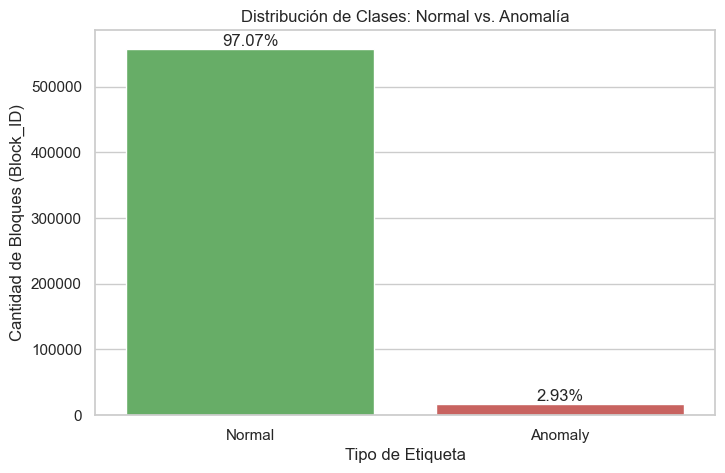

In [6]:
# Cargar las etiquetas de anomalías
try:
    labels_df = pd.read_csv("dataset/preprocessed/anomaly_label.csv")

    print(labels_df.head())
    print("\n--- Distribución de Clases (Normal vs. Anomalía) ---")

    # Contar los valores
    label_counts = labels_df['Label'].value_counts()
    print(label_counts)

    # Calcular porcentaje (lo usaremos para los prints y las anotaciones)
    total = len(labels_df)
    
    # --- MODIFICACIÓN INICIA ---

    # Graficar la distribución
    plt.figure(figsize=(8, 5))
    
    # 1. Captura el eje (axes) en una variable 'ax'
    ax = sns.countplot(x='Label', data=labels_df, hue="Label", legend=False, palette=['#5cb85c', '#d9534f'])
    
    plt.title('Distribución de Clases: Normal vs. Anomalía')
    plt.ylabel('Cantidad de Bloques (Block_ID)')
    plt.xlabel('Tipo de Etiqueta')

    # 2. Agrega un bucle para anotar cada barra
    for p in ax.patches:
        height = p.get_height()           # Obtiene la altura (conteo) de la barra
        percentage = 100 * height / total # Calcula el porcentaje
        
        # Prepara el texto de la etiqueta
        label_text = f'{percentage:.2f}%' 

        # Añade el texto al gráfico
        ax.text(
            p.get_x() + p.get_width() / 2,  # Posición X (en el centro de la barra)
            height,                         # Posición Y (justo en la parte superior de la barra)
            label_text,                     # El texto a mostrar
            ha='center',                    # Alineación horizontal
            va='bottom'                     # Alineación vertical (para que empiece *sobre* la barra)
        )
    
    # --- MODIFICACIÓN TERMINA ---

    # Imprimir los porcentajes en la consola (como ya lo tenías)
    normal_pct = (label_counts['Normal'] / total) * 100
    anomaly_pct = (label_counts['Anomaly'] / total) * 100

    print(f"\nPorcentaje Normal: {normal_pct:.2f}%")
    print(f"Porcentaje Anomalía: {anomaly_pct:.2f}%")

    plt.show()

except FileNotFoundError:
    print("Error: No se encontró el archivo 'dataset/preprocessed/anomaly_label.csv'.")
    print("Asegúrate de que la ruta sea correcta.")

**Insight Clave del EDA:** El gráfico confirma que el dataset es **extremadamente desbalanceado**. Menos del 3% de las muestras son anomalías. Esto justifica por qué debemos usar `Recall` y `F1-Score` como métricas principales y no `Accuracy`.

### Parte 2 (Continuación): Preprocesamiento e Ingeniería de Características

El paso para convertir `HDFS.log` en datos numéricos que un modelo pueda entender es:

1.  **Parsing (Análisis):** Se usa un algoritmo para leer todos los logs crudos y extraer "plantillas" de eventos. (Ej. `Receiving block * from *` es una plantilla). El archivo `HDFS.log_templates.csv` contiene estas plantillas.
2.  **Agrupación:** Se agrupan las secuencias de logs por el `Block_ID` al que pertenecen.
3.  **Vectorización (Ingeniería de Características):** Para cada `Block_ID`, se cuenta cuántas veces apareció cada "plantilla" de evento en su secuencia.

Este proceso es muy complejo. Afortunadamente, el dataset nos provee el resultado de este paso en el archivo `Event_occurrence_matrix.csv`. Vamos a cargar esta matriz para usarla como nuestras características (`X`).

In [7]:
# Cargar la matriz de características (X)
try:
    features_df = pd.read_csv("dataset/preprocessed/Event_occurrence_matrix.csv")

    # Cargar las etiquetas (y)
    labels_df = pd.read_csv("dataset/preprocessed/anomaly_label.csv")

    # Limpiar nombres de columnas por si acaso (elimina espacios)
    features_df.columns = features_df.columns.str.strip()
    labels_df.columns = labels_df.columns.str.strip()
    
    # Unir las características con las etiquetas usando el Block_ID
    # Asumiendo que la columna se llama 'BlockId' en ambos, según tu código
    data_df = pd.merge(features_df, labels_df, on='BlockId')

    print("--- Datos combinados (Características + Etiquetas) ---")
    print(data_df.head())

    # Inspeccionar los datos
    print("\n--- Información del DataFrame ---")
    data_df.info()

except FileNotFoundError:
    print("Error: No se encontraron los archivos en 'dataset/preprocessed/'.")
    print("Asegúrate de que la ruta sea correcta.")
except KeyError as e:
    print(f"Error de Llave (KeyError): No se encontró la columna {e} para hacer el merge.")
    print("Verifica los nombres de las columnas en tus archivos CSV.")

--- Datos combinados (Características + Etiquetas) ---
                    BlockId  Label_x  Type  E1  E2   E3  E4  E5  E6  E7  ...  \
0  blk_-1608999687919862906  Success   NaN   0   0  203   0  10   7   0  ...   
1   blk_7503483334202473044  Success   NaN   0   2    1   0   3   0   0  ...   
2  blk_-3544583377289625738     Fail  21.0   0   0  203   0   3   0   0  ...   
3  blk_-9073992586687739851  Success   NaN   0   3    0   0   3   0   0  ...   
4   blk_7854771516489510256  Success   NaN   0   3    1  15   3   0   0  ...   

   E21  E22  E23  E24  E25  E26  E27  E28  E29  Label_y  
0   10    1   10    0    4   10    0    0    0   Normal  
1    3    1    3    0    0    3    0    0    0   Normal  
2    3    1    3    0    0    3    0    0    0  Anomaly  
3    3    1    3    0    0    3    0    0    0   Normal  
4    3    1    3    0    0    3    0    0    0   Normal  

[5 rows x 33 columns]

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 e

### Estandarización de datos

In [10]:
# --- 1. Separar X e y ---
# X son solo las columnas de eventos (E1...E29)
# Eliminamos las columnas de texto y la columna 'Type' que tiene NaNs
X = data_df.drop(columns=['BlockId', 'Label_x', 'Type', 'Label_y'])

# y es la etiqueta que queremos predecir (Normal/Anomaly)
y_text = data_df['Label_y']

# Convertir etiquetas de texto a números (0 = Normal, 1 = Anomaly)
y = y_text.apply(lambda x: 1 if x == 'Anomaly' else 0)

print("Forma de X (características):", X.shape)
print("Forma de y (objetivo):", y.shape)

Forma de X (características): (575061, 29)
Forma de y (objetivo): (575061,)


In [11]:
from sklearn.model_selection import train_test_split

# --- 2. Dividir en Entrenamiento y Prueba ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% para prueba
    random_state=42,  # Para reproducibilidad
    stratify=y        # ¡Crucial para desbalanceo!
)

print(f"Tamaño de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de Prueba: {X_test.shape[0]} muestras")
print(f"Proporción de Anomalías en Prueba: {y_test.mean():.3f}")

Tamaño de Entrenamiento: 460048 muestras
Tamaño de Prueba: 115013 muestras
Proporción de Anomalías en Prueba: 0.029


### Implementación de Regresión Logística

--- Estandarizando los datos ---
¡Datos estandarizados con éxito!

--- Entrenando el modelo de Regresión Logística ---
¡Modelo de Regresión Logística entrenado con éxito!

--- Evaluación del modelo en el conjunto de prueba ---

--- Reporte de Clasificación (Regresión Logística) ---
                    precision    recall  f1-score   support

  Normal (Clase 0)       1.00      1.00      1.00    111645
Anomalía (Clase 1)       0.96      1.00      0.98      3368

          accuracy                           1.00    115013
         macro avg       0.98      1.00      0.99    115013
      weighted avg       1.00      1.00      1.00    115013


--- Matriz de Confusión (Regresión Logística) ---


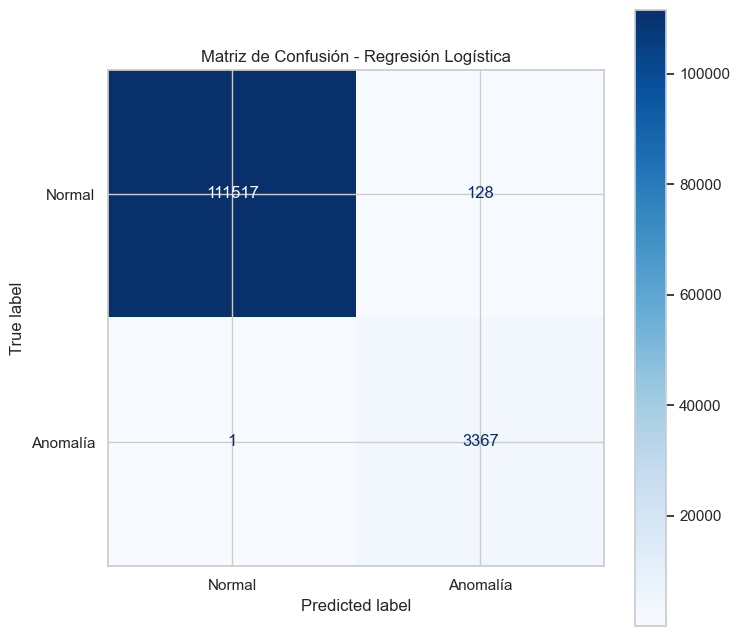

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paso Adicional: Estandarización de Datos ---
# La Regresión Logística es sensible a la escala de las características.
print("--- Estandarizando los datos ---")
scaler = StandardScaler()

# Ajustamos el scaler SOLO con los datos de entrenamiento para evitar fuga de datos
X_train_scaled = scaler.fit_transform(X_train)

# Aplicamos la misma transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test)

print("¡Datos estandarizados con éxito!")


# --- Implementación del Modelo de Regresión Logística ---
print("\n--- Entrenando el modelo de Regresión Logística ---")

# 1. Crear el modelo
# Usamos class_weight='balanced' para que el modelo preste más atención a la clase minoritaria (Anomalía)
log_reg_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000  # Aumentamos las iteraciones para asegurar la convergencia
)

# 2. Entrenar el modelo con los datos estandarizados
log_reg_model.fit(X_train_scaled, y_train)

print("¡Modelo de Regresión Logística entrenado con éxito!")


# --- Evaluación del Modelo de Regresión Logística ---
print("\n--- Evaluación del modelo en el conjunto de prueba ---")

# 3. Hacer predicciones en el conjunto de prueba estandarizado
y_pred_log_reg = log_reg_model.predict(X_test_scaled)

# 4. Mostrar el Reporte de Clasificación
print("\n--- Reporte de Clasificación (Regresión Logística) ---")
print(classification_report(y_test, y_pred_log_reg, target_names=['Normal (Clase 0)', 'Anomalía (Clase 1)']))

# 5. Mostrar la Matriz de Confusión
print("\n--- Matriz de Confusión (Regresión Logística) ---")
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_reg,
    display_labels=['Normal', 'Anomalía']
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Matriz de Confusión - Regresión Logística')
plt.show()